<a href="https://colab.research.google.com/github/chiruvallika/web-practise/blob/stress_project/stressDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from textblob import TextBlob
import nltk
import re
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/content/dreaddit-train.csv")
test = pd.read_csv("/content/dreaddit-test.csv")

In [3]:
full = train.append(test)
full.shape

(3553, 116)

In [4]:
print("Rows :", full.shape[0])
print("Columns :", full.shape[1])
print()
print("Categorical columns :")
print(full.select_dtypes(include=['object']).apply(pd.Series.nunique, axis=0))
print()
print("Description :")
print(full.info())
print()
print("Nulls:")
print(full.isnull().sum())

Rows : 3553
Columns : 116

Categorical columns :
subreddit           10
post_id           2929
sentence_range     194
text              3532
dtype: int64

Description :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3553 entries, 0 to 714
Columns: 116 entries, subreddit to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 3.2+ MB
None

Nulls:
subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


In [5]:
full.sample()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
435,assistance,7grypl,"[5, 10]",We couldn’t have Thanksgiving because of money...,903,1,1.0,1.512097e+09,4,8.722162,...,1.0,1.0,1.0,1.74822,1.72941,1.85687,0.61,2,8.163495,0.057639


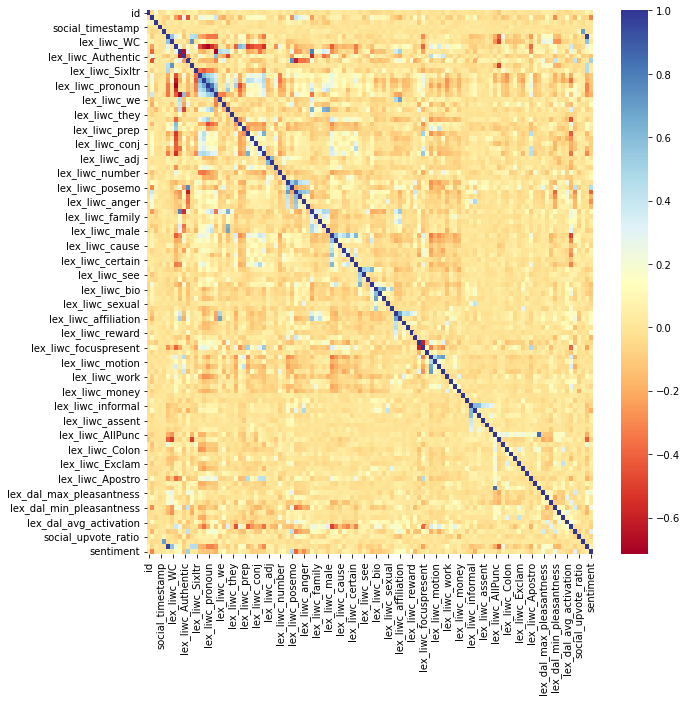

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(full.corr(), cmap = "RdYlBu")

In [7]:
#Positive Sentiment
print("Positive Sentiment :")
print("Polarity : ",TextBlob("greatest").polarity)
print("Sentiment : ",TextBlob("greatest").sentiment)
print()
#Negative Sentiment
print("Negative Sentiment :")
print("Polarity : ",TextBlob("worst").polarity)
print("Sentiment : ",TextBlob("worst").sentiment)

Positive Sentiment :
Polarity :  1.0
Sentiment :  Sentiment(polarity=1.0, subjectivity=1.0)

Negative Sentiment :
Polarity :  -1.0
Sentiment :  Sentiment(polarity=-1.0, subjectivity=1.0)


In [8]:
#Sentiment Detection
def mood(txt):
    return TextBlob(txt).sentiment.polarity

In [9]:
#Get text
posts = full[["text"]]

In [10]:
#Adding Mood Detection as column
posts["sentiment"] = posts["text"].apply(mood)
posts.head()

,text,sentiment
0,"He said he had not felt that way before, sugge...",-0.002742
1,"Hey there r/assistance, Not sure if this is th...",0.292857
2,My mom then hit me with the newspaper and it s...,0.011894
3,"until i met my new boyfriend, he is amazing, h...",0.141671
4,October is Domestic Violence Awareness Month a...,-0.204167


In [11]:
print("Value Exploration :")
print("Minimum Sentiment :", posts["sentiment"].min())
print("Maximum Sentiment :", posts["sentiment"].max())
print()
print("Counts :")
print(posts.sentiment.value_counts())

Value Exploration :
Minimum Sentiment : -1.0
Maximum Sentiment : 1.0

Counts :
 0.000000    84
 0.250000    24
 0.100000    23
 0.150000    17
 0.125000    16
             ..
 0.200926     1
-0.009375     1
-0.045833     1
 0.244643     1
 0.136364     1
Name: sentiment, Length: 2627, dtype: int64


In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
def removal(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [w for w in text.split(' ') if w not in stopwords]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
posts["text"] = posts["text"].apply(removal)
posts["text"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0      said felt way before, sugget go rest ..trigger...
1      hey r/assistance, sure right place post this.....
2      mom hit newspap shock would this, know like pl...
3      met new boyfriend, amazing, kind, sweet, good ...
4      octob domest violenc awar month domest violenc...
                             ...                        
710    horribl vivid nightmar everi night. sometim th...
711    also can't think without get angri jealous aga...
712    furthermore, told got realli serious anxieti d...
713    here link amazon wish list two item are:  link...
714    keep us protected? alreadi told unwelcom perso...
Name: text, Length: 3553, dtype: object

In [17]:
#Adding meaning to text from og dataset
posts["meaning"] = full["label"].map({0:"Unstressed", 1:"Stressed"})
#posts = posts[["text", "meaning"]]
posts.head()

,text,sentiment,meaning
0,"said felt way before, sugget go rest ..trigger...",-0.002742,Stressed
1,"hey r/assistance, sure right place post this.....",0.292857,Unstressed
2,"mom hit newspap shock would this, know like pl...",0.011894,Stressed
3,"met new boyfriend, amazing, kind, sweet, good ...",0.141671,Stressed
4,octob domest violenc awar month domest violenc...,-0.204167,Stressed


In [18]:
#Applying sentiment
posts["sentiment"] = posts["text"].apply(mood)
posts.head()

,text,sentiment,meaning
0,"said felt way before, sugget go rest ..trigger...",0.027273,Stressed
1,"hey r/assistance, sure right place post this.....",0.360714,Unstressed
2,"mom hit newspap shock would this, know like pl...",0.199273,Stressed
3,"met new boyfriend, amazing, kind, sweet, good ...",0.190156,Stressed
4,octob domest violenc awar month domest violenc...,-0.085714,Stressed


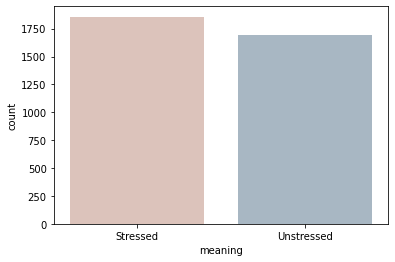

In [19]:
#sns.displot(x=posts.meaning, kind='kde')
sns.countplot(x='meaning',data = posts, palette= ["#e1c0b6", "#a3b8c8"])

In [20]:
#Assign variables; x = features & y = target
x = posts.text
y = posts.meaning

In [21]:
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x)

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=43)

In [23]:
from sklearn.linear_model import LogisticRegression
m2=LogisticRegression().fit(x_train, y_train)
score = m2.score(x_test,y_test)
#accuracy_score(m2,y_test)
print("Model Accuracy is {p}%".format(p =round (score*100, 2)))

Model Accuracy is 72.44%


In [24]:
#Using Logistic Regression
prompt = "The weather is pleasant"
p = vect.transform([prompt]).toarray()
op = m2.predict(p)
print(op)

['Unstressed']
